# Adversarial Examples on MNIST: Reproducing Szegedy et al. and Goodfellow et al.

This notebook trains convolutional neural networks on MNIST and studies:
- Fast Gradient Sign Method (FGSM) adversarial examples
- Adversarial training with FGSM
- L-BFGS adversarial examples (approximation)
- Transferability of adversarial examples between two models


In [9]:
import os
import math
import random
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [10]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [14]:
import os, gzip

raw_folder = "./data/MNIST/raw"
print("Files in raw folder:")
for fname in os.listdir(raw_folder):
    path = os.path.join(raw_folder, fname)
    size = os.path.getsize(path)
    print(f"  {fname:35s} {size:10d} bytes")
    if fname.endswith(".gz"):
        try:
            with gzip.open(path, "rb") as f:
                f.read(1)  # try to read 1 byte
            print("    -> gzip OK")
        except Exception as e:
            print("    -> gzip BROKEN:", repr(e))


Files in raw folder:
  .ipynb_checkpoints                        4096 bytes
  t10k-labels-idx1-ubyte.gz                 4542 bytes
    -> gzip OK
  train-images-idx3-ubyte.gz             9912422 bytes
    -> gzip OK
  train-labels-idx1-ubyte.gz               28881 bytes
    -> gzip OK
  t10k-images-idx3-ubyte.gz              1648877 bytes
    -> gzip OK


In [15]:
import os
import torch
import numpy as np
import gzip

raw_folder = "./data/MNIST/raw"
processed_folder = "./data/MNIST/processed"
os.makedirs(processed_folder, exist_ok=True)

def open_maybe_gz(path):
    if path.endswith(".gz"):
        return gzip.open(path, "rb")
    return open(path, "rb")

def read_images(filename):
    path = os.path.join(raw_folder, filename)
    with open_maybe_gz(path) as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16).copy()
    return torch.from_numpy(data).view(-1, 28, 28)

def read_labels(filename):
    path = os.path.join(raw_folder, filename)
    with open_maybe_gz(path) as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=8).copy()
    return torch.from_numpy(data).long()

train_images = read_images("train-images-idx3-ubyte.gz")
train_labels = read_labels("train-labels-idx1-ubyte.gz")
test_images  = read_images("t10k-images-idx3-ubyte.gz")
test_labels  = read_labels("t10k-labels-idx1-ubyte.gz")

print("Train images:", train_images.shape, "Train labels:", train_labels.shape)
print("Test images:",  test_images.shape,  "Test labels:",  test_labels.shape)

torch.save((train_images, train_labels), os.path.join(processed_folder, "training.pt"))
torch.save((test_images,  test_labels),  os.path.join(processed_folder, "test.pt"))

print("Saved processed MNIST to", processed_folder)


Train images: torch.Size([60000, 28, 28]) Train labels: torch.Size([60000])
Test images: torch.Size([10000, 28, 28]) Test labels: torch.Size([10000])
Saved processed MNIST to ./data/MNIST/processed


In [16]:
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_TEST  = 256

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_ds = datasets.MNIST(root="./data", train=True, download=False, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=False, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE_TEST,  shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)


(60000, 10000)

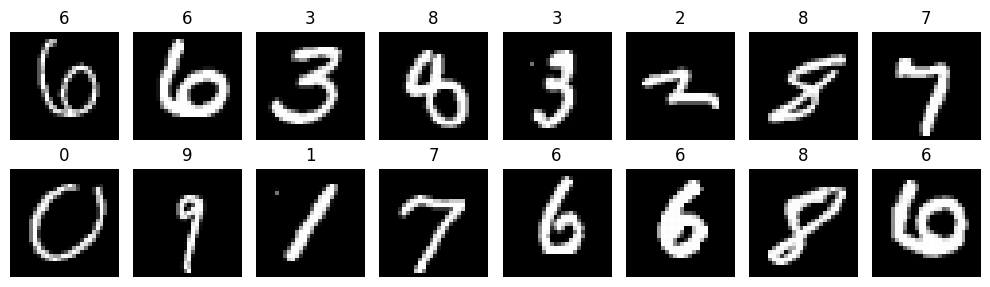

In [17]:
%matplotlib inline

examples, labels = next(iter(train_loader))
fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(examples[i, 0].numpy(), cmap="gray")
    ax.set_title(int(labels[i]))
    ax.axis("off")
plt.tight_layout()


In [18]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1   = nn.Linear(7 * 7 * 64, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # 28x28 -> 14x14
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # 14x14 -> 7x7
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def count_params(model):
    return sum(p.numel() for p in model.parameters())

baseline_model = SimpleCNN().to(device)
print("Baseline model parameters:", count_params(baseline_model))


Baseline model parameters: 454922


In [19]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc  = total_correct / len(loader.dataset)
    return avg_loss, avg_acc


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc  = total_correct / len(loader.dataset)
    return avg_loss, avg_acc


In [20]:
EPOCHS_BASELINE = 6
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=LR)

baseline_history = {"train_acc": [], "test_acc": []}

for epoch in range(1, EPOCHS_BASELINE + 1):
    tr_loss, tr_acc = train_epoch(baseline_model, train_loader, optimizer, criterion)
    te_loss, te_acc = evaluate(baseline_model, test_loader, criterion)
    baseline_history["train_acc"].append(tr_acc)
    baseline_history["test_acc"].append(te_acc)

    print(f"[Baseline] Epoch {epoch:02d} | "
          f"train loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"test loss={te_loss:.4f}, acc={te_acc:.4f}")


/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.2.0/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987296916/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


[Baseline] Epoch 01 | train loss=0.2047, acc=0.9366 | test loss=0.0571, acc=0.9825
[Baseline] Epoch 02 | train loss=0.0499, acc=0.9842 | test loss=0.0432, acc=0.9864
[Baseline] Epoch 03 | train loss=0.0337, acc=0.9893 | test loss=0.0329, acc=0.9898
[Baseline] Epoch 04 | train loss=0.0252, acc=0.9919 | test loss=0.0323, acc=0.9897
[Baseline] Epoch 05 | train loss=0.0198, acc=0.9939 | test loss=0.0319, acc=0.9902
[Baseline] Epoch 06 | train loss=0.0166, acc=0.9948 | test loss=0.0283, acc=0.9905


In [21]:
def fgsm_attack(model, x, y, epsilon):
    """
    Fast Gradient Sign Method (FGSM).
    x: input batch in [0,1]
    y: correct labels
    epsilon: L-infinity perturbation bound
    """
    model.eval()
    x_adv = x.clone().detach().to(device)
    x_adv.requires_grad = True
    y = y.to(device)

    logits = model(x_adv)
    loss = F.cross_entropy(logits, y)
    model.zero_grad()
    loss.backward()

    # sign of gradient
    grad_sign = x_adv.grad.data.sign()
    x_adv = x_adv + epsilon * grad_sign

    # project back to valid pixel range
    x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()
    return x_adv


In [22]:
def evaluate_fgsm(model, loader, epsilon):
    model.eval()
    total = 0
    correct_clean = 0
    correct_adv   = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        total += x.size(0)

        # clean
        with torch.no_grad():
            logits_clean = model(x)
        preds_clean = logits_clean.argmax(dim=1)
        correct_clean += (preds_clean == y).sum().item()

        # adversarial
        x_adv = fgsm_attack(model, x, y, epsilon)
        with torch.no_grad():
            logits_adv = model(x_adv)
        preds_adv = logits_adv.argmax(dim=1)
        correct_adv += (preds_adv == y).sum().item()

    print(f"Epsilon={epsilon:.3f} | "
          f"clean acc={correct_clean/total:.4f} | "
          f"FGSM acc={correct_adv/total:.4f}")

EPSILONS = [0.05, 0.10, 0.15, 0.25]
for eps in EPSILONS:
    evaluate_fgsm(baseline_model, test_loader, eps)


Epsilon=0.050 | clean acc=0.9905 | FGSM acc=0.9500
Epsilon=0.100 | clean acc=0.9905 | FGSM acc=0.8166
Epsilon=0.150 | clean acc=0.9905 | FGSM acc=0.5728
Epsilon=0.250 | clean acc=0.9905 | FGSM acc=0.1773


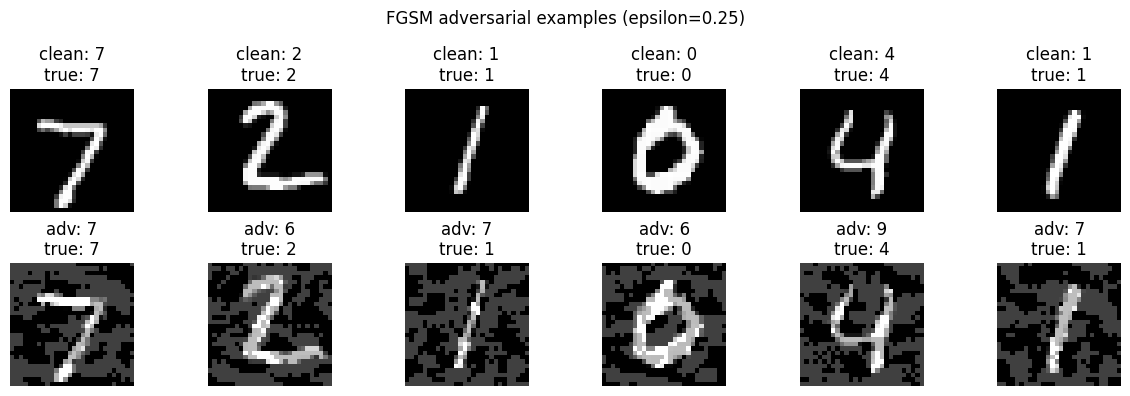

In [23]:
def show_adversarial_examples(model, loader, epsilon, n_examples=6):
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)

    x_adv = fgsm_attack(model, x, y, epsilon)

    with torch.no_grad():
        pred_clean = model(x).argmax(dim=1)
        pred_adv   = model(x_adv).argmax(dim=1)

    x = x.cpu()
    x_adv = x_adv.cpu()
    y = y.cpu()
    pred_clean = pred_clean.cpu()
    pred_adv = pred_adv.cpu()

    fig, axes = plt.subplots(2, n_examples, figsize=(2*n_examples, 4))
    for i in range(n_examples):
        axes[0, i].imshow(x[i, 0], cmap="gray")
        axes[0, i].set_title(f"clean: {pred_clean[i].item()}\ntrue: {y[i].item()}")
        axes[0, i].axis("off")

        axes[1, i].imshow(x_adv[i, 0], cmap="gray")
        axes[1, i].set_title(f"adv: {pred_adv[i].item()}\ntrue: {y[i].item()}")
        axes[1, i].axis("off")

    plt.suptitle(f"FGSM adversarial examples (epsilon={epsilon})")
    plt.tight_layout()

show_adversarial_examples(baseline_model, test_loader, epsilon=0.25)


In [24]:
def train_epoch_adv(model, loader, optimizer, epsilon=0.25, alpha=0.5):
    """
    Adversarial training:
    loss = alpha * loss(clean) + (1-alpha) * loss(FGSM-perturbed)
    """
    model.train()
    total_loss, total_correct = 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # clean loss
        logits_clean = model(x)
        loss_clean = F.cross_entropy(logits_clean, y)

        # adversarial examples
        x_adv = fgsm_attack(model, x, y, epsilon)
        logits_adv = model(x_adv)
        loss_adv = F.cross_entropy(logits_adv, y)

        loss = alpha * loss_clean + (1 - alpha) * loss_adv

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits_clean.argmax(dim=1)
        total_correct += (preds == y).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc  = total_correct / len(loader.dataset)
    return avg_loss, avg_acc


In [25]:
adv_model = SimpleCNN().to(device)
criterion_adv = nn.CrossEntropyLoss()
optimizer_adv = torch.optim.Adam(adv_model.parameters(), lr=LR)

EPOCHS_ADV = 6
EPSILON_TRAIN = 0.25
ALPHA = 0.5

adv_history = {"train_acc": [], "test_acc": []}

for epoch in range(1, EPOCHS_ADV + 1):
    tr_loss, tr_acc = train_epoch_adv(
        adv_model, train_loader, optimizer_adv,
        epsilon=EPSILON_TRAIN, alpha=ALPHA
    )
    te_loss, te_acc = evaluate(adv_model, test_loader, criterion_adv)
    adv_history["train_acc"].append(tr_acc)
    adv_history["test_acc"].append(te_acc)

    print(f"[AdvTrain] Epoch {epoch:02d} | "
          f"train loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"test loss={te_loss:.4f}, acc={te_acc:.4f}")


[AdvTrain] Epoch 01 | train loss=0.5725, acc=0.9379 | test loss=0.0768, acc=0.9746
[AdvTrain] Epoch 02 | train loss=0.2491, acc=0.9797 | test loss=0.0416, acc=0.9863
[AdvTrain] Epoch 03 | train loss=0.0597, acc=0.9865 | test loss=0.0327, acc=0.9896
[AdvTrain] Epoch 04 | train loss=0.0360, acc=0.9896 | test loss=0.0296, acc=0.9902
[AdvTrain] Epoch 05 | train loss=0.0264, acc=0.9916 | test loss=0.0317, acc=0.9897
[AdvTrain] Epoch 06 | train loss=0.0175, acc=0.9933 | test loss=0.0259, acc=0.9918


In [26]:
print("Baseline model robustness:")
for eps in EPSILONS:
    evaluate_fgsm(baseline_model, test_loader, eps)

print("\nAdversarially-trained model robustness:")
for eps in EPSILONS:
    evaluate_fgsm(adv_model, test_loader, eps)


Baseline model robustness:
Epsilon=0.050 | clean acc=0.9905 | FGSM acc=0.9500
Epsilon=0.100 | clean acc=0.9905 | FGSM acc=0.8166
Epsilon=0.150 | clean acc=0.9905 | FGSM acc=0.5728
Epsilon=0.250 | clean acc=0.9905 | FGSM acc=0.1773

Adversarially-trained model robustness:
Epsilon=0.050 | clean acc=0.9918 | FGSM acc=0.9853
Epsilon=0.100 | clean acc=0.9918 | FGSM acc=0.9866
Epsilon=0.150 | clean acc=0.9918 | FGSM acc=0.9893
Epsilon=0.250 | clean acc=0.9918 | FGSM acc=0.9914


In [27]:
def lbfgs_adversarial_example(model, x, target_label, c=1.0, max_iter=50):
    """
    Targeted L-BFGS style attack on a single image.
    x: (1,1,28,28) in [0,1]
    target_label: integer target class
    c: trade-off between distortion and classification loss
    """
    model.eval()
    x = x.to(device)
    target = torch.tensor([target_label], dtype=torch.long, device=device)

    # r is the perturbation
    r = torch.zeros_like(x, requires_grad=True)
    optimizer = torch.optim.LBFGS([r], max_iter=max_iter, lr=0.1)

    def closure():
        optimizer.zero_grad()
        x_adv = torch.clamp(x + r, 0.0, 1.0)
        logits = model(x_adv)
        loss_ce = F.cross_entropy(logits, target)

        # L2 norm of r
        l2 = torch.norm(r.view(r.size(0), -1), p=2, dim=1).mean()
        loss = c * l2 + loss_ce
        loss.backward()
        return loss

    optimizer.step(closure)
    x_adv = torch.clamp(x + r, 0.0, 1.0).detach()
    r_final = (x_adv - x).detach()
    return x_adv, r_final


True label:   7
Clean pred:   7
Adversarial pred (target=8): 8
L2 distortion: 2.7196545600891113


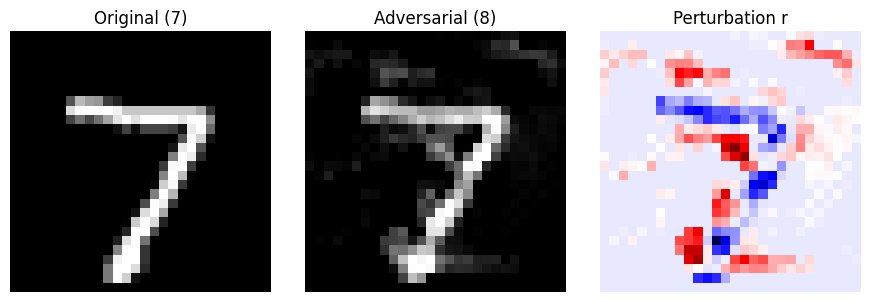

In [28]:
# take one image
x_batch, y_batch = next(iter(test_loader))
x0 = x_batch[0:1]        # shape (1,1,28,28)
y0 = y_batch[0].item()

target_label = (y0 + 1) % 10  # simple different target

x_lbfgs, r_lbfgs = lbfgs_adversarial_example(
    baseline_model, x0, target_label, c=1.0, max_iter=50
)

with torch.no_grad():
    pred_clean = baseline_model(x0.to(device)).argmax(1).item()
    pred_adv   = baseline_model(x_lbfgs.to(device)).argmax(1).item()

print(f"True label:   {y0}")
print(f"Clean pred:   {pred_clean}")
print(f"Adversarial pred (target={target_label}): {pred_adv}")
print("L2 distortion:", torch.norm(r_lbfgs.view(-1)).item())

# visualize
x0_cpu = x0[0, 0].cpu().numpy()
x_adv_cpu = x_lbfgs[0, 0].cpu().numpy()
r_cpu = r_lbfgs[0, 0].cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(x0_cpu, cmap="gray")
axes[0].set_title(f"Original ({y0})")
axes[0].axis("off")

axes[1].imshow(x_adv_cpu, cmap="gray")
axes[1].set_title(f"Adversarial ({pred_adv})")
axes[1].axis("off")

axes[2].imshow(r_cpu, cmap="seismic")
axes[2].set_title("Perturbation r")
axes[2].axis("off")

plt.tight_layout()


In [29]:
model_A = deepcopy(baseline_model)  # already trained
model_B = SimpleCNN().to(device)    # new model to train

optimizer_B = torch.optim.Adam(model_B.parameters(), lr=LR)
EPOCHS_B = 6

for epoch in range(1, EPOCHS_B + 1):
    tr_loss, tr_acc = train_epoch(model_B, train_loader, optimizer_B, criterion)
    te_loss, te_acc = evaluate(model_B, test_loader, criterion)
    print(f"[Model B] Epoch {epoch:02d} | "
          f"train loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"test loss={te_loss:.4f}, acc={te_acc:.4f}")


[Model B] Epoch 01 | train loss=0.1960, acc=0.9401 | test loss=0.0468, acc=0.9843
[Model B] Epoch 02 | train loss=0.0511, acc=0.9841 | test loss=0.0369, acc=0.9883
[Model B] Epoch 03 | train loss=0.0354, acc=0.9885 | test loss=0.0364, acc=0.9878
[Model B] Epoch 04 | train loss=0.0262, acc=0.9916 | test loss=0.0293, acc=0.9907
[Model B] Epoch 05 | train loss=0.0204, acc=0.9932 | test loss=0.0285, acc=0.9903
[Model B] Epoch 06 | train loss=0.0163, acc=0.9946 | test loss=0.0225, acc=0.9917


In [30]:
def transfer_attack_error(model_src, model_tgt, loader, epsilon):
    model_src.eval()
    model_tgt.eval()
    total = 0
    err_src = 0
    err_tgt = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        total += x.size(0)

        # adversarial examples crafted on model_src
        x_adv = fgsm_attack(model_src, x, y, epsilon)

        with torch.no_grad():
            logits_src = model_src(x_adv)
            logits_tgt = model_tgt(x_adv)

        pred_src = logits_src.argmax(1)
        pred_tgt = logits_tgt.argmax(1)

        err_src += (pred_src != y).sum().item()
        err_tgt += (pred_tgt != y).sum().item()

    print(f"Transfer FGSM attack (epsilon={epsilon}):")
    print(f"  Source model error: {err_src/total:.4f}")
    print(f"  Target model error: {err_tgt/total:.4f}")

transfer_attack_error(model_A, model_B, test_loader, epsilon=0.25)
transfer_attack_error(model_B, model_A, test_loader, epsilon=0.25)


Transfer FGSM attack (epsilon=0.25):
  Source model error: 0.8227
  Target model error: 0.6575
Transfer FGSM attack (epsilon=0.25):
  Source model error: 0.8377
  Target model error: 0.6208


In [32]:

os.makedirs("checkpoints", exist_ok=True)
torch.save(baseline_model.state_dict(), "checkpoints/baseline_cnn.pt")
torch.save(adv_model.state_dict(),      "checkpoints/adv_trained_cnn.pt")
torch.save(model_B.state_dict(),        "checkpoints/modelB_cnn.pt")

print("Models saved.")



Models saved.


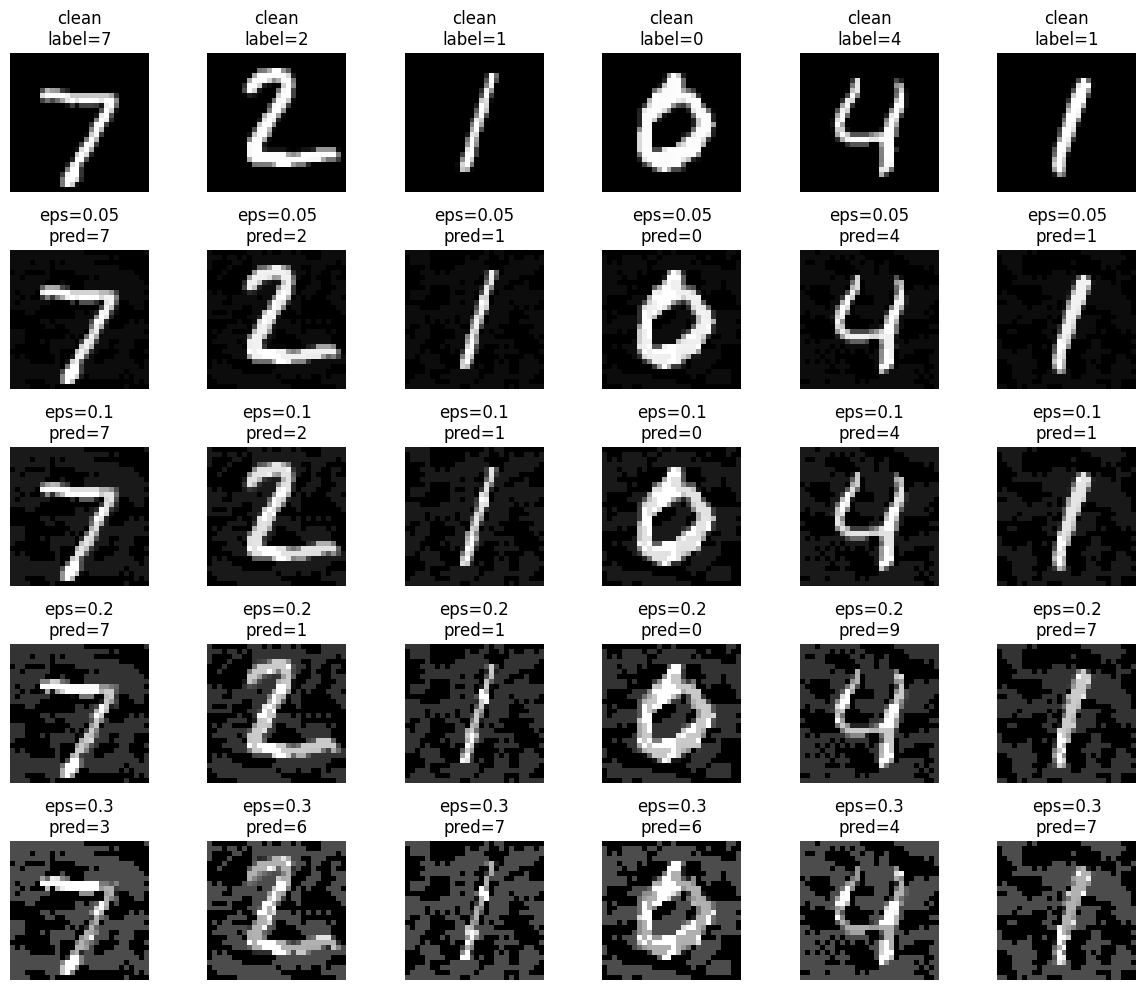

In [33]:
def visualize_fgsm_strength(model, loader, eps_list=[0.05, 0.10, 0.20, 0.30], n=6):
    model.eval()
    x, y = next(iter(loader))
    x, y = x[:n].to(device), y[:n].to(device)

    fig, axes = plt.subplots(len(eps_list)+1, n, figsize=(2*n, 2*(len(eps_list)+1)))

    # Row 0: original images
    for i in range(n):
        axes[0, i].imshow(x[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title(f"clean\nlabel={y[i].item()}")
        axes[0, i].axis("off")

    # Rows for each epsilon
    for row, eps in enumerate(eps_list, start=1):
        x_adv = fgsm_attack(model, x, y, eps)
        preds = model(x_adv).argmax(1)

        for i in range(n):
            axes[row, i].imshow(x_adv[i, 0].cpu(), cmap='gray')
            axes[row, i].set_title(f"eps={eps}\npred={preds[i].item()}")
            axes[row, i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_fgsm_strength(baseline_model, test_loader)


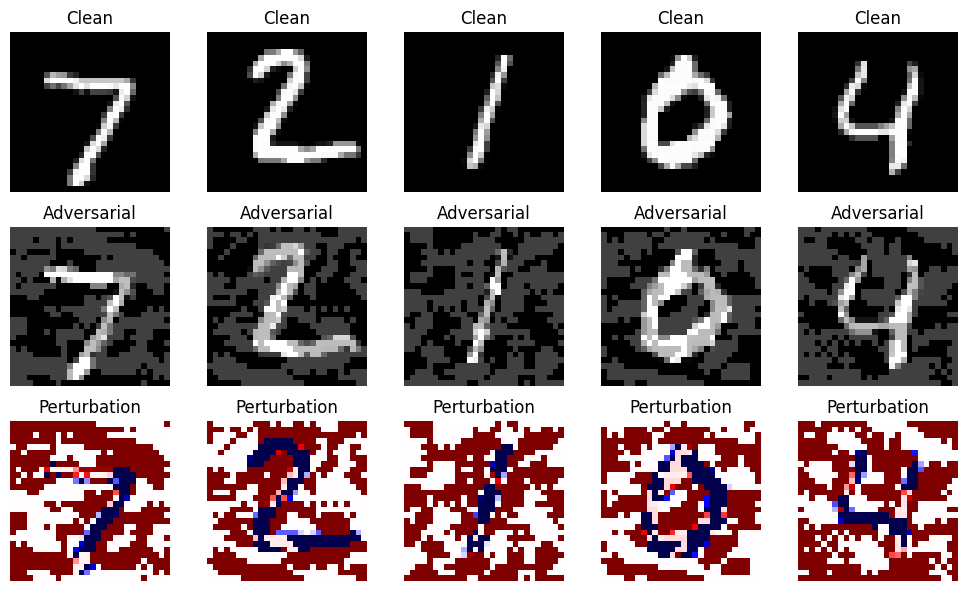

In [34]:
def visualize_fgsm_perturbation(model, loader, eps=0.25, n=5):
    model.eval()
    x, y = next(iter(loader))
    x, y = x[:n].to(device), y[:n].to(device)

    x_adv = fgsm_attack(model, x, y, eps)
    perturb = (x_adv - x).cpu()

    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))

    for i in range(n):
        axes[0, i].imshow(x[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title("Clean")
        axes[0, i].axis("off")

        axes[1, i].imshow(x_adv[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title("Adversarial")
        axes[1, i].axis("off")

        axes[2, i].imshow(perturb[i, 0], cmap='seismic')
        axes[2, i].set_title("Perturbation")
        axes[2, i].axis("off")

    plt.tight_layout()

visualize_fgsm_perturbation(baseline_model, test_loader)


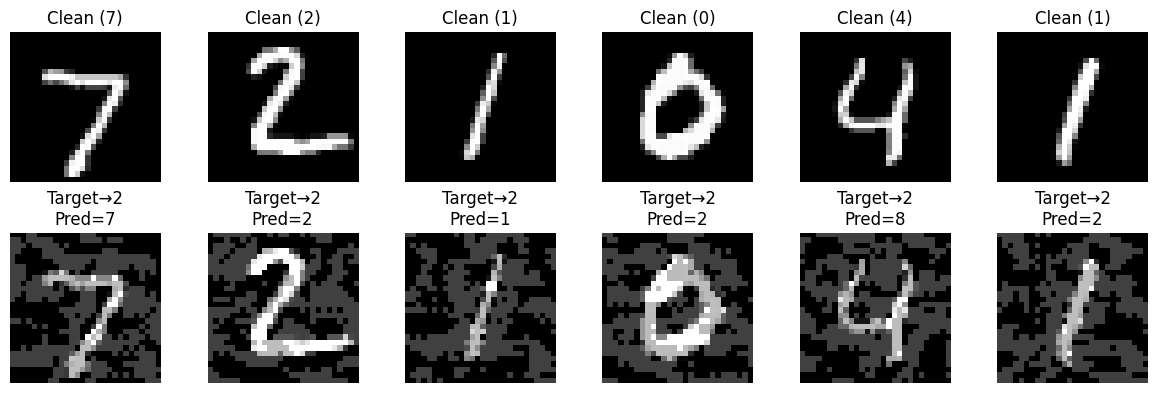

In [35]:
def targeted_fgsm(model, x, target_label, eps):
    x_adv = x.clone().detach().to(device)
    x_adv.requires_grad = True
    target = torch.tensor([target_label], device=device)

    logits = model(x_adv)
    loss = F.cross_entropy(logits, target)
    model.zero_grad()
    loss.backward()

    grad = x_adv.grad.data.sign()
    x_adv = torch.clamp(x_adv - eps * grad, 0, 1)
    return x_adv.detach()

def visualize_targeted_fgsm(model, loader, eps=0.25, target_label=2, n=6):
    model.eval()
    x, y = next(iter(loader))
    x, y = x[:n].to(device), y[:n].to(device)

    x_adv = torch.cat([targeted_fgsm(model, x[i:i+1], target_label, eps) for i in range(n)], dim=0)
    preds = model(x_adv).argmax(1)

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    for i in range(n):
        axes[0, i].imshow(x[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title(f"Clean ({y[i].item()})")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(x_adv[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title(f"Target→{target_label}\nPred={preds[i].item()}")
        axes[1, i].axis("off")

    plt.tight_layout()

visualize_targeted_fgsm(baseline_model, test_loader)


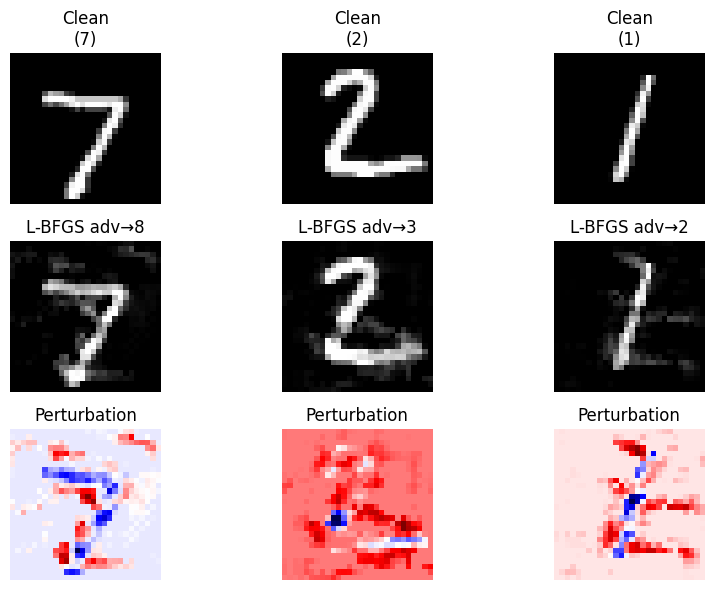

In [36]:
def visualize_lbfgs(model, loader, target_label=None, n=3):
    model.eval()
    x, y = next(iter(loader))
    x = x[:n].to(device)
    y = y[:n]

    fig, axes = plt.subplots(3, n, figsize=(3*n, 6))

    for i in range(n):
        t = target_label if target_label is not None else (y[i].item() + 1) % 10
        
        x_adv, r = lbfgs_adversarial_example(model, x[i:i+1], t, c=1.0)
        
        axes[0, i].imshow(x[i,0].cpu(), cmap="gray")
        axes[0, i].set_title(f"Clean\n({y[i].item()})")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(x_adv[0,0].cpu(), cmap="gray")
        axes[1, i].set_title(f"L-BFGS adv→{t}")
        axes[1, i].axis("off")
        
        axes[2, i].imshow(r[0,0].cpu(), cmap="seismic")
        axes[2, i].set_title("Perturbation")
        axes[2, i].axis("off")

    plt.tight_layout()

visualize_lbfgs(baseline_model, test_loader)


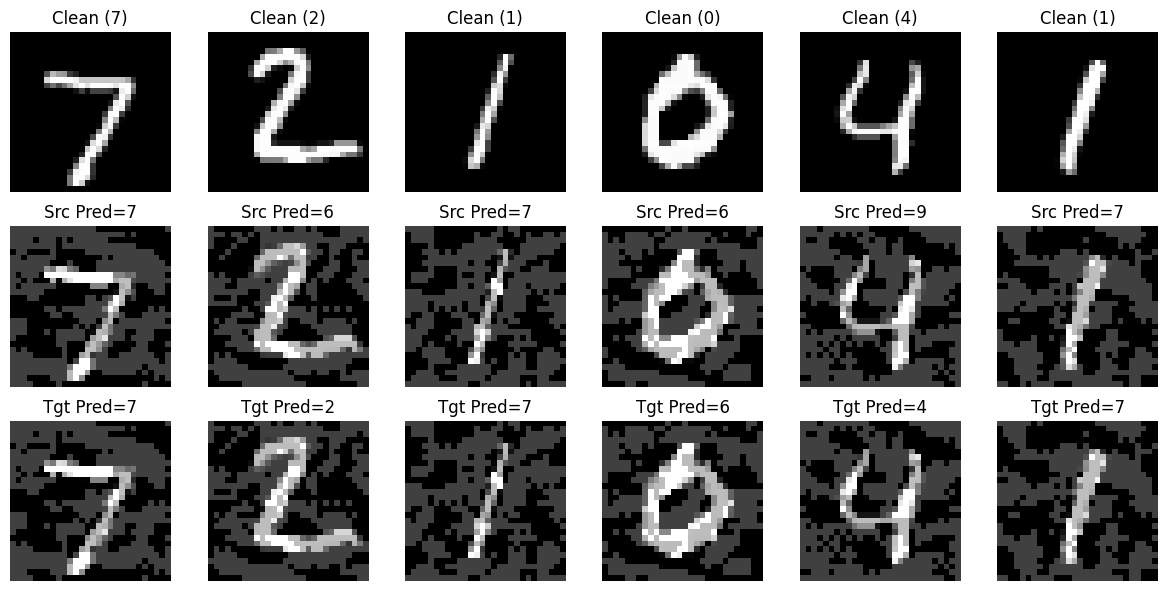

In [37]:
def visualize_transfer(model_src, model_tgt, loader, eps=0.25, n=6):
    x, y = next(iter(loader))
    x, y = x[:n].to(device), y[:n].to(device)

    x_adv = fgsm_attack(model_src, x, y, eps)

    pred_src = model_src(x_adv).argmax(1)
    pred_tgt = model_tgt(x_adv).argmax(1)

    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))
    
    for i in range(n):
        axes[0, i].imshow(x[i,0].cpu(), cmap='gray')
        axes[0, i].set_title(f"Clean ({y[i].item()})")
        axes[0, i].axis("off")

        axes[1, i].imshow(x_adv[i,0].cpu(), cmap='gray')
        axes[1, i].set_title(f"Src Pred={pred_src[i].item()}")
        axes[1, i].axis("off")

        axes[2, i].imshow(x_adv[i,0].cpu(), cmap='gray')
        axes[2, i].set_title(f"Tgt Pred={pred_tgt[i].item()}")
        axes[2, i].axis("off")

    plt.tight_layout()

visualize_transfer(model_A, model_B, test_loader)


In [39]:
class SimpleCNN2D(nn.Module):
    """
    CNN with a 2D latent space before the final classification layer.
    This makes it easy to visualize decision boundaries in 2D.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc_latent = nn.Linear(7 * 7 * 64, 2)   # 2D latent
        self.fc_out    = nn.Linear(2, 10)           # 10 classes

    def get_latent(self, x):
        # compute 2D latent representation z
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        z = self.fc_latent(x)
        return z

    def classify_from_latent(self, z):
        # logits from 2D latent
        return self.fc_out(z)

    def forward(self, x):
        z = self.get_latent(x)
        logits = self.classify_from_latent(z)
        return logits



In [40]:
model_2d = SimpleCNN2D().to(device)
criterion_2d = nn.CrossEntropyLoss()
optimizer_2d = torch.optim.Adam(model_2d.parameters(), lr=1e-3)

EPOCHS_2D = 5  # you can increase if you like

for epoch in range(1, EPOCHS_2D + 1):
    tr_loss, tr_acc = train_epoch(model_2d, train_loader, optimizer_2d, criterion_2d)
    te_loss, te_acc = evaluate(model_2d, test_loader, criterion_2d)
    print(f"[2D CNN] Epoch {epoch:02d} | "
          f"train loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"test loss={te_loss:.4f}, acc={te_acc:.4f}")


[2D CNN] Epoch 01 | train loss=1.0380, acc=0.6285 | test loss=0.6147, acc=0.8148
[2D CNN] Epoch 02 | train loss=0.5244, acc=0.8534 | test loss=0.4557, acc=0.8751
[2D CNN] Epoch 03 | train loss=0.4111, acc=0.8944 | test loss=0.3706, acc=0.9090
[2D CNN] Epoch 04 | train loss=0.3475, acc=0.9145 | test loss=0.3214, acc=0.9210
[2D CNN] Epoch 05 | train loss=0.3020, acc=0.9267 | test loss=0.3533, acc=0.9108


In [41]:
import numpy as np

def get_latent_2d(model, loader, max_batches=None):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for b, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            z = model.get_latent(x)        # (B, 2)
            latents.append(z.cpu())
            labels.append(y.cpu())
            if max_batches is not None and b + 1 >= max_batches:
                break
    latents = torch.cat(latents, dim=0).numpy()
    labels  = torch.cat(labels,  dim=0).numpy()
    return latents, labels

latents_2d, labels_2d = get_latent_2d(model_2d, test_loader)
latents_2d.shape, labels_2d.shape


((10000, 2), (10000,))

In [ ]:
from matplotlib.colors import ListedColormap

def plot_2d_decision_boundaries(model, latents, labels, n_points=300):
    """
    model: trained SimpleCNN2D
    latents: (N, 2) numpy array
    labels: (N,) numpy array of digit labels
    """
    model.eval()
    x_min, x_max = latents[:, 0].min() - 1.0, latents[:, 0].max() + 1.0
    y_min, y_max = latents[:, 1].min() - 1.0, latents[:, 1].max() + 1.0

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, n_points),
        np.linspace(y_min, y_max, n_points)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]  # (n_points^2, 2)

    with torch.no_grad():
        grid_t = torch.from_numpy(grid).float().to(device)
        logits = model.classify_from_latent(grid_t)
        preds  = logits.argmax(1).cpu().numpy()

    Z = preds.reshape(xx.shape)

    # nice colormap for 10 digits
    cmap_background = ListedColormap([
        "#FFCCCC", "#FFE5CC", "#FFFFCC", "#E5FFCC", "#CCFFCC",
        "#CCFFE5", "#CCFFFF", "#CCE5FF", "#CCCCFF", "#E5CCFF"
    ])
    cmap_points = plt.cm.tab10

    plt.figure(figsize=(8, 6))
    # decision regions
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_background)

    # scatter points
    scatter = plt.scatter(
        latents[:, 0], latents[:, 1],
        c=labels, cmap=cmap_points,
        edgecolors="k", s=10, alpha=0.8
    )

    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.set_label("Digit class")
    plt.title("2D latent space with decision boundaries")
    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.tight_layout()
    plt.show()

plot_2d_decision_boundaries(model_2d, latents_2d, labels_2d)
